In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Activation, Normalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.data import Dataset
import tensorflow as tf
%matplotlib inline

# Motivation
* Current ML surface layer parameterization trains based on fixed z level observations.
* However, MOST assumes a constant flux with height within surface layer and effectively scales the wind, temperature, and moisture gradients with the exchange coefficient.
* If we include z as an input and train with multiple z values rather than 1, can the NN learn to be robust to the height of the measurement?

In [2]:
class IdahoDataset(Dataset):
    def _generator():
        train_data = pd.read_csv("/Users/dgagne/data/idaho_derived_data_20210720.csv")
        zs = np.array([2, 10, 15, 45])
        wind_speed_cols = train_data.columns[train_data.columns.str.startswith("wind_speed:")][:-1]
        potential_temperature_cols = train_data.columns[train_data.columns.str.startswith("potential_temperature:")]
        while True:
            row = np.random.randint(0, train_data.shape[0], 1)
            zi = np.random.random(1) * (zs.max() - zs.min()) + zs.min()
            wind_spline = InterpolatedUnivariateSpline(zs, np.log(train_data.loc[row, wind_speed_cols]), k=3)
            temp_spline = InterpolatedUnivariateSpline(zs, train_data.loc[row, potential_temperature_cols], k=3)
            wind_i = (wind_spline(zi) - 1.2) / 0.7
            temp_i = (temp_spline(zi) - 297.) / 10.0
            skin_temp = (train_data.loc[row, 'skin_potential_temperature:0_m:K'] - 297) / 10
            z_n = (np.log(zi) - 3) / 0.1
            yield np.array([wind_i, temp_i, skin_temp, z_n], dtype=np.float32).T, np.log(train_data.loc[row, 'friction_velocity:surface:m_s-1'])
    
    def __new__(cls):
        return tf.data.Dataset.from_generator(cls._generator, output_types=(tf.float32, tf.float32))
    
class IdahoDatasetNoZ(Dataset):
    def _generator():
        train_data = pd.read_csv("/Users/dgagne/data/idaho_derived_data_20210720.csv")
        zs = np.array([2, 10, 15, 45])
        wind_speed_cols = train_data.columns[train_data.columns.str.startswith("wind_speed:")][:-1]
        potential_temperature_cols = train_data.columns[train_data.columns.str.startswith("potential_temperature:")]
        while True:
            row = np.random.randint(0, train_data.shape[0], 1)
            zi = np.random.random(1) * (zs.max() - zs.min()) + zs.min()
            wind_spline = InterpolatedUnivariateSpline(zs, np.log(train_data.loc[row, wind_speed_cols]), k=3)
            temp_spline = InterpolatedUnivariateSpline(zs, train_data.loc[row, potential_temperature_cols], k=3)
            wind_i = (wind_spline(zi) - 1.2) / 0.7
            temp_i = (temp_spline(zi) - 297.) / 10.0
            skin_temp = (train_data.loc[row, 'skin_potential_temperature:0_m:K'] - 297) / 10
            z_n = (np.log(zi) - 3) / 0.1
            yield np.array([wind_i, temp_i, skin_temp], dtype=np.float32).T, np.log(train_data.loc[row, 'friction_velocity:surface:m_s-1'])
    
    def __new__(cls):
        return tf.data.Dataset.from_generator(cls._generator, output_types=(tf.float32, tf.float32))
        

In [11]:
data = pd.read_csv("/Users/dgagne/data/idaho_derived_data_20210720.csv")


In [510]:
data.columns

Index(['Time', 'wind_speed:2_m:m_s-1', 'wind_gust:2_m:m_s-1',
       'wind_direction:2_m:degrees', 'sigma_theta:2_m:degrees',
       'wind_speed:10_m:m_s-1', 'wind_gust:10_m:m_s-1',
       'wind_direction:10_m:degrees', 'sigma_theta:10_m:degrees',
       'wind_speed:15_m:m_s-1', 'wind_gust:15_m:m_s-1',
       'wind_direction:15_m:degrees', 'sigma_theta:15_m:degrees',
       'wind_speed:45_m:m_s-1', 'wind_gust:45_m:m_s-1',
       'wind_direction:45_m:degrees', 'sigma_theta:45_m:degrees',
       'wind_speed:top:m_s-1', 'wind_gust:top:m_s-1',
       'wind_direction:top:degrees', 'sigma_theta:top:degrees',
       'relative_humidity:2_m:%', 'GHI_met_tower:0_m:W_m-2',
       'BP_inches:0_m:inches_hg', 'Rain:0_m:inches',
       'Water_Content:5_cm:m3_m-3', 'Water_Content:10_cm:m3_m-3',
       'Water_Content:20_cm:m3_m-3', 'Water_Content:50_cm:m3_m-3',
       'Water_Content:100_cm:m3_m-3', 'Soil_Temp:5_cm:C', 'Soil_Temp:10_cm:C',
       'Soil_Temp:20_cm:C', 'Soil_Temp:50_cm:C', 'Soil_Temp:100_

In [5]:
model = Sequential()
model.add(Dense(64, kernel_regularizer=l2(0.0001), input_shape=(4,)))
model.add(Activation('relu'))
model.add(Dense(64, kernel_regularizer=l2(0.0001)))
model.add(Activation('relu'))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")

2022-01-31 09:50:24.241340: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
ds = IdahoDataset()
model.fit(ds, batch_size=128, steps_per_epoch=1000, epochs=10)

2022-01-31 09:50:38.705971: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1000/1000 [==============================] - 4s 3ms/step - loss: 0.5676
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5050
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2619
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2403
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2147
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2277
Epoch 7/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2030
Epoch 8/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2253
Epoch 9/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2021
Epoch 10/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1771


In [7]:
modelnoz = Sequential()
modelnoz.add(Dense(64, kernel_regularizer=l2(0.0001), input_shape=(3,)))
modelnoz.add(Activation('relu'))
modelnoz.add(Dense(64, kernel_regularizer=l2(0.0001)))
modelnoz.add(Activation('relu'))
modelnoz.add(Dense(1))
modelnoz.compile(loss="mse", optimizer="adam")

In [8]:
dsz = IdahoDatasetNoZ()
modelnoz.fit(dsz, batch_size=128, steps_per_epoch=1000, epochs=10)

Epoch 1/10
1000/1000 [==============================] - 4s 3ms/step - loss: 0.3933
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4468
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2641
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2859
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2056
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1967
Epoch 7/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1875
Epoch 8/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1744
Epoch 9/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3048
Epoch 10/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1828


In [124]:
np.log(data[wind_speed_cols]).std()

wind_speed:2_m:m_s-1     0.712367
wind_speed:10_m:m_s-1    0.678766
wind_speed:15_m:m_s-1    0.691344
wind_speed:45_m:m_s-1    0.711906
dtype: float64

In [96]:
data[potential_temperature_cols].mean()

potential_temperature:2_m:K     296.596599
potential_temperature:10_m:K    297.076415
potential_temperature:15_m:K    297.195705
potential_temperature:45_m:K    297.615612
dtype: float64

In [105]:
data[potential_temperature_cols].std()

potential_temperature:2_m:K     12.160813
potential_temperature:10_m:K    11.654074
potential_temperature:15_m:K    11.556672
potential_temperature:45_m:K    11.274580
dtype: float64

Text(0, 0.5, 'Height (m)')

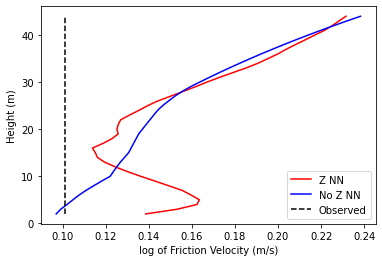

In [48]:
zs = np.array([2, 10, 15, 45], dtype=float)
wind_speed_cols = data.columns[data.columns.str.startswith("wind_speed:")][:-1]
potential_temperature_cols = data.columns[data.columns.str.startswith("potential_temperature:")]
row = np.random.randint(0, data.shape[0], 1)
zi_range = np.arange(2, 45, 1)
wind_spline = InterpolatedUnivariateSpline(zs, np.log(data.loc[row, wind_speed_cols]), k=1)
temp_spline = InterpolatedUnivariateSpline(zs, data.loc[row, potential_temperature_cols], k=1)
wind_i = (wind_spline(zi_range) - 1.2) / 0.7
temp_i = (temp_spline(zi_range) - 297) / 10
zi_n = (np.log(zi_range) - 3) / 0.1
skin_temp_n = np.ones(wind_i.shape[0])
skin_temp_n = skin_temp_n *  ((data.loc[row, 'skin_potential_temperature:0_m:K'].values - 297) / 10)
skin_temp_n.shape
int_row_ex = np.vstack([wind_i, temp_i, skin_temp_n, zi_n]).T
mod_z_height_pred = model.predict(int_row_ex)
mod_noz_height_pred = modelnoz.predict(int_row_ex[:, :-1])
plt.plot(np.exp(mod_z_height_pred), zi_range, "r-", label="Z NN")
plt.plot(np.exp(mod_noz_height_pred), zi_range, "b-", label="No Z NN")
actual_log_fv = np.log(data.loc[row, 'friction_velocity:surface:m_s-1'].values)
plt.plot(np.ones(zi_range.shape) * np.exp(actual_log_fv), zi_range, 'k--', label="Observed")
plt.legend()
plt.xlabel("log of Friction Velocity (m/s)")
plt.ylabel("Height (m)")

In [39]:
wspd_lognorm = (np.log(data["wind_speed:45_m:m_s-1"].values) - 1.2) / 0.7
temp_norm = (data["potential_temperature:45_m:K"].values - 297) / 10
zs_norm = (np.log(np.ones(wspd_lognorm.shape) * 45) - 3) / 0.1
skin_temp = (data.loc[:, 'skin_potential_temperature:0_m:K'] - 297) / 10

pred_data_45 = np.vstack([wspd_lognorm, temp_norm, skin_temp, zs_norm]).T

In [17]:
wspd_lognorm = (np.log(data["wind_speed:10_m:m_s-1"].values) - 1.2) / 0.7
temp_norm = (data["potential_temperature:10_m:K"].values - 297) / 10
zs_norm = (np.log(np.ones(wspd_lognorm.shape) * 10) - 3) / 0.1
skin_temp = (data.loc[:, 'skin_potential_temperature:0_m:K'] - 297) / 10

pred_data_10 = np.vstack([wspd_lognorm, temp_norm, skin_temp, zs_norm]).T

In [18]:
outputs_45 = model.predict(pred_data_45)
outputs_10 = model.predict(pred_data_10)

In [19]:
outputs_noz_45 = modelnoz.predict(pred_data_45[:, :-1])
outputs_noz_10 = modelnoz.predict(pred_data_10[:, :-1])

Text(0, 0.5, 'Skin Temperature Weights')

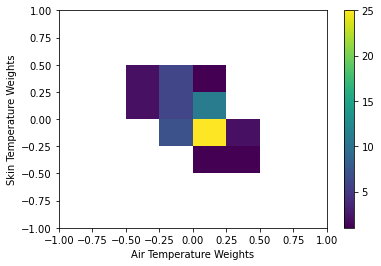

In [25]:
plt.hist2d(model.layers[0].get_weights()[0][1], 
           model.layers[0].get_weights()[0][2], 
           bins=np.arange(-1, 1.25, 0.25), cmin=1)
plt.colorbar()
plt.xlabel("Air Temperature Weights")
plt.ylabel("Skin Temperature Weights")

Text(0.5, 0, 'Z weights')

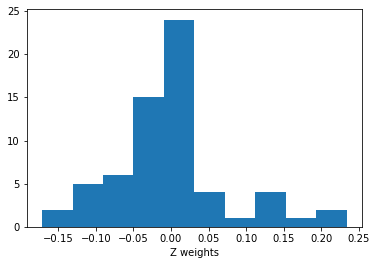

In [49]:
plt.hist(model.layers[0].get_weights()[0][3])
plt.xlabel("Z weights")

Text(0.5, 1.0, 'No Z NN')

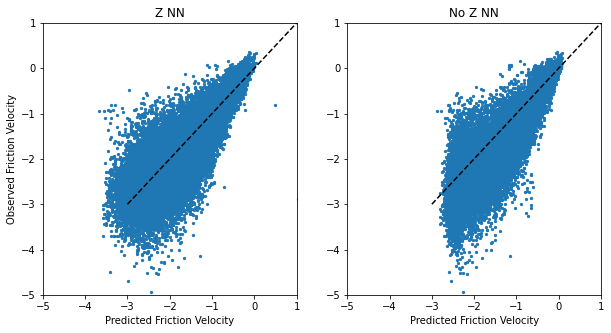

In [52]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(outputs_45, np.log(data['friction_velocity:surface:m_s-1']), 5)
plt.plot(np.arange(-3, 1.1, 0.1), np.arange(-3, 1.1, 0.1), 'k--')
plt.ylabel("Observed Friction Velocity")
plt.xlim(-5, 1)
plt.ylim(-5, 1)
plt.xlabel("Predicted Friction Velocity")
plt.title("Z NN")
plt.subplot(1, 2, 2)
plt.scatter(outputs_noz_45, np.log(data['friction_velocity:surface:m_s-1']), 5)
plt.plot(np.arange(-3, 1.1, 0.1), np.arange(-3, 1.1, 0.1), 'k--')
plt.xlim(-5, 1)
plt.ylim(-5, 1)
plt.xlabel("Predicted Friction Velocity")
plt.title("No Z NN")


(-5.0, 1.0)

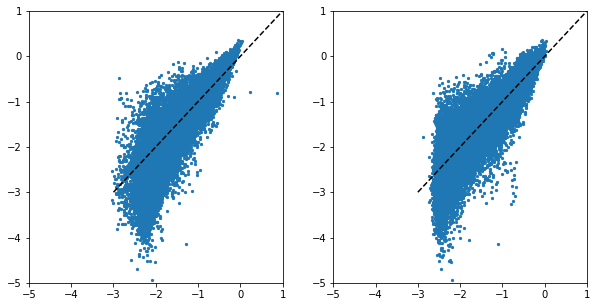

In [31]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(outputs_10, np.log(data['friction_velocity:surface:m_s-1']), 5)
plt.plot(np.arange(-3, 1.1, 0.1), np.arange(-3, 1.1, 0.1), 'k--')
plt.xlim(-5, 1)
plt.ylim(-5, 1)
plt.subplot(1, 2, 2)
plt.scatter(outputs_noz_10, np.log(data['friction_velocity:surface:m_s-1']), 5)
plt.plot(np.arange(-3, 1.1, 0.1), np.arange(-3, 1.1, 0.1), 'k--')
plt.xlim(-5, 1)
plt.ylim(-5, 1)

(array([8.0000e+00, 7.7000e+01, 5.8100e+02, 2.1070e+03, 3.4600e+03,
        8.9210e+03, 1.4907e+04, 5.7230e+03, 1.2510e+03, 1.2800e+02]),
 array([-1.4372352 , -1.2053367 , -0.97343826, -0.7415397 , -0.50964123,
        -0.27774274, -0.04584425,  0.18605426,  0.41795275,  0.64985126,
         0.88174975], dtype=float32),
 <BarContainer object of 10 artists>)

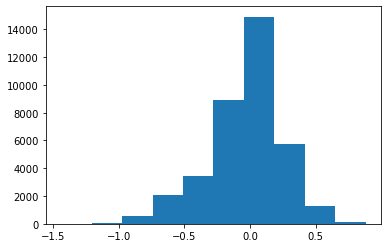

In [32]:
plt.hist(outputs_45-outputs_10)

In [34]:
np.mean((outputs_10.ravel() - np.log(data['friction_velocity:surface:m_s-1'].values)) **2)

0.17723481054828494

In [36]:
np.mean((outputs_noz_10.ravel() - np.log(data['friction_velocity:surface:m_s-1'].values)) **2)

0.1545728907645095

In [176]:
data[["wind_speed:15_m:m_s-1", "potential_temperature:15_m:K"]].values

array([[  7.        , 278.91152062],
       [  5.7       , 279.87928402],
       [  5.5       , 280.67769661],
       ...,
       [  1.4       , 275.86378573],
       [  1.3       , 275.64339507],
       [  0.6       , 275.30384876]])

In [378]:
np.log(data.loc[row, 'friction_velocity:surface:m_s-1'])

4563   -0.559388
Name: friction_velocity:surface:m_s-1, dtype: float64

In [427]:
pub_data = pd.read_csv("/Users/dgagne/data/WebOfScience_AI_ML_Atmos_Meteorology.txt", sep="\t").sort_values("Publication Years")

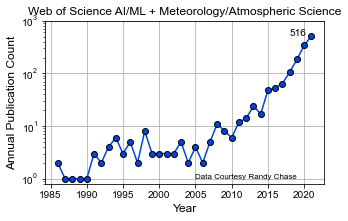

In [488]:
plt.figure(figsize=(5, 3))
plt.rcParams["font.family"] = "arial"
plt.semilogy(pub_data["Publication Years"][:-1], pub_data["Record Count"][:-1], color='#0343DF', marker='o', markeredgecolor='k')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Annual Publication Count", fontsize=12)
#plt.plot(pub_data["Publication Years"][:-1], np.ones(pub_data["Publication Years"][:-1].size) * 10, 'k--')
plt.grid()
plt.text(2018, 516, "516")
plt.ylim(0.8, 1000)
plt.title("Web of Science AI/ML + Meteorology/Atmospheric Science")
plt.text(2005, 1, "Data Courtesy Randy Chase", fontsize=8)
plt.savefig("/Users/dgagne/aiml_papers.png", dpi=300, bbox_inches="tight", facecolor="w")

In [503]:
(pub_data["Record Count"].values[-10:-1] - pub_data["Record Count"].values[-11:-2]) / pub_data["Record Count"].values[-11:-2]

array([ 0.71428571, -0.29166667,  1.82352941,  0.10416667,  0.20754717,
        0.65625   ,  0.73584906,  0.8423913 ,  0.52212389])

In [505]:
np.log(2) / np.log(1 + 0.52)

1.6554336562882084

In [506]:
#@jit(nopython=True)
def mo_similarity(u10, v10, tsk, t2, qsfc, q2, psfc, mavail=1, z0=0.01, zt0=0.001, z10=10.0, z2=2.0):
    """
    Calculate flux information based on Monin-Obukhov similarity theory.
    Args:
        u10: 10 m level zonal wind speed [m/s]
        v10: 10 m level meridional wind speed [m/s]
        tsk: surface skin temperature [K]
        t2: 2 m level temperature [K]
        qsfc: ground mixing ratio [kg /kg]
        q2: 2 m level mixing ratio [kg / kg]
        psfc: surface pressure [hPa]
        z0: momentum roughness length
        zt0: heat flux roughness length
        z10: Height of "10 m" layer
        z2: Height of "2 m" layer
    Returns:
        ustar: friction velocity
        tstar: temperature scale
        wthv0: -ustar * tstar
        zeta10: z/L for a z of 10 m. Used for momentum flux
        phim10: momentum universal function at 10 m
        zeta2: z/L for a z of 2 m.
        phih2: sensible heat flux universal function at 2 m.
    """
    if z0 > 0:
        z10oz0 = z10 / z0
        z2oz0 = z2 / z0
        z2ozt0 = z2 / zt0
    else:
        raise ValueError("z0 must be greater than 0")
    # else:
    #    sys.exit("Surface roughnes, z0, must be greter than 0.!")
    #
    # Gravitational acceleration
    g = 9.81
    #
    # Gas constant over spcific heat capacity at constant pressure
    r = 287.058
    cp = 1005.
    rocp = r / cp
    #
    # Reference pressure and temperature
    p0 = 1000.
    t0 = 300.
    #
    # Set M-O parameters based on Dyer 1974 paper
    karman = 0.4
    beta = 5.0
    gamma = 16.0
    #
    # Air density
    rho = psfc / (r * t2)
    #
    # Potential temperature speed at level 1
    th2 = t2 * (p0 / psfc) ** rocp
    th0 = tsk * (p0 / psfc) ** rocp
    #
    # Virtual potential temperature
    thv2 = th2 * (1. + 0.61 * q2)
    thv0 = th0 * (1. + 0.61 * qsfc)
    #
    # Small number
    epsilon = 1.e-6
    #
    # Initial values of drag coefficients - neutrally stratified case
    cd = karman ** 2 / ((log(z10oz0)) ** 2)
    ch = karman ** 2 / ((log(z2ozt0)) ** 2)
    cq = karman ** 2 / ((log(z2ozt0)) ** 2)
    #
    # Initial values of surface friction velocity, temperature scale, and
    # heat flux
    wind_speed = sqrt(u10 * u10 + v10 * v10)
    if wind_speed < 0.1:
        wind_speed = 0.1
        u10 = 0.1
    tauxz = cd * wind_speed * u10
    tauyz = cd * wind_speed * v10
    ustar = (tauxz ** 2 + tauyz ** 2) ** 0.25

    tstar = -ch / ustar * wind_speed * (thv0 - thv2)
    qstar = cq / ustar * mavail * wind_speed * (qsfc - q2)
    wthv0 = -ustar * tstar
    #
    # Set stopping criterion
    diff = 1.
    #
    # Set stability functions
    psim10 = 0.
    psim2 = 0.
    psih2 = 0.
    psiq2 = 0.
    phim10 = 0.
    phih2 = 0
    #
    zeta10 = 0.
    zeta2 = 0.
    count = 0
    while diff > epsilon and count < 100:
        #
        # Surface friction velocity and temperature scale
        tauxz = cd * wind_speed * u10
        tauyz = cd * wind_speed * v10
        ustar = (tauxz ** 2 + tauyz ** 2) ** 0.25
        if ustar < 0.01:
            ustar = 0.01
        wspd2 = ustar / karman * (log(z2oz0) - psim2)
        tstar = -ch / ustar * wspd2 * (thv0 - thv2)
        qstar = cq / ustar * mavail * wspd2 * (qsfc - q2)
        wthv0 = -ustar * tstar
        #
        # Compute drag coefficients
        cdold = cd
        chold = ch
        cqold = cq
        #
        # Neutrally stratified case
        if wthv0 == 0:
            zeta10 = 0.
            zeta2 = 0.
            psim10 = 0.
            psim2 = 0.
            psih2 = 0.
            psiq2 = 0.
            phim10 = 1.
            phih2 = 1.
            cd = karman ** 2 / ((log(z10oz0)) ** 2)
            ch = karman ** 2 / ((log(z2ozt0)) ** 2)
            cq = karman ** 2 / ((log(z2ozt0)) ** 2)
        elif abs(wthv0) > 0:
            #
            # Obukhov length scale
            olength = -ustar ** 3 / (karman * g / t0 * wthv0)
            if abs(olength) < 10 and olength > 0:
                olength = z10
            elif abs(olength) < 10 and olength < 0:
                olength = -z10
            #
            # Free convection
            # if (olength == 0.):
            #    sys.exit("Free convection!")
            #
            # Monin-Obukhov stability parameter
            zeta10 = z10 / olength
            zeta2 = z2 / olength
            #
            # Convective case
            if (zeta2 < -epsilon) & (zeta10 >= -2.):
                xi10 = 1. / ((1. - gamma * zeta10) ** 0.25)
                xi2 = 1. / ((1. - gamma * zeta2) ** 0.25)
                psim10 = log(0.5 * (1.0 + xi10 ** 2) * (0.5 * (1.0 + xi10)) ** 2) \
                    - 2. * atan(xi10) + 0.5 * np.pi
                psim2 = log(0.5 * (1.0 + xi2 ** 2) * (0.5 * (1.0 + xi2)) ** 2) \
                    - 2. * atan(xi2) + 0.5 * np.pi
                psih2 = 2.0 * log(0.5 * (1.0 + xi2 ** 2))
                psiq2 = 2.0 * log(0.5 * (1.0 + xi2 ** 2))
                phim10 = 1. / ((1. - gamma * zeta10) ** 0.25)
                phih2 = 1. / ((1. - gamma * zeta2) ** 0.25)
            #
            # Stably stratified case
            elif (zeta2 > epsilon) & (zeta2 <= 1.):
                psim10 = - beta * zeta10
                psim2 = - beta * zeta2
                psih2 = - beta * zeta2
                psiq2 = - beta * zeta2
                phim10 = (1. + beta * zeta10)
                phih2 = (1. + beta * zeta2)
            #
            # Neutrally stratified case
            elif (zeta2 <= epsilon) & (zeta2 >= -epsilon):
                psim10 = 0.
                psim2 = 0.
                psih2 = 0.
                psiq2 = 0.
                phim10 = 1.
                phih2 = 1.
            #
            cd = karman ** 2 / ((log(z10oz0) - psim10) ** 2)
            ch = karman ** 2 / ((log(z2ozt0) - psim2) * (log(z2ozt0) - psih2))
            cq = karman ** 2 / ((log(z2ozt0) - psim2) * (log(z2ozt0) - psiq2))
        #
        diff = abs(cd - cdold) + abs(ch - chold) + abs(cq - cqold)
        count += 1
    #
    return ustar, tstar, qstar, wthv0, zeta10, phim10, zeta2, phih2